## Import libraries and load data

In [111]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools
from scipy.interpolate import interp1d
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsa
from pylab import rcParams
import scipy.stats as ss
import datetime as dt

In [187]:
df = pd.read_csv('../data/option_with_vol.csv')
df = df[['timestamp', 'spot', '1700', '1700_vol']]
df = df.rename(columns = {'1700':'price', '1700_vol':'volume'})
df.head()

,timestamp,spot,price,volume
0,2022-09-01 00:00:00,1564.625,238.996469,67628.0
1,2022-09-01 00:10:00,1557.725,235.216475,65656.0
2,2022-09-01 00:20:00,1556.975,235.103225,64104.0
3,2022-09-01 00:30:00,1545.425,229.495612,95785.0
4,2022-09-01 00:40:00,1541.975,227.441313,157334.0


In [42]:
df.shape

(8784, 4)

## Data preprocessing

In [183]:
# Create new variable y for option price with strike price 1700
df.set_index('timestamp', inplace = True)
y = df['price']

### Decomposition

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose y into trend, seasonal, and residual
decomposition = seasonal_decompose(y, model = 'multiplicative', period = 144*7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

<AxesSubplot:title={'center':'Trend'}, xlabel='timestamp'>

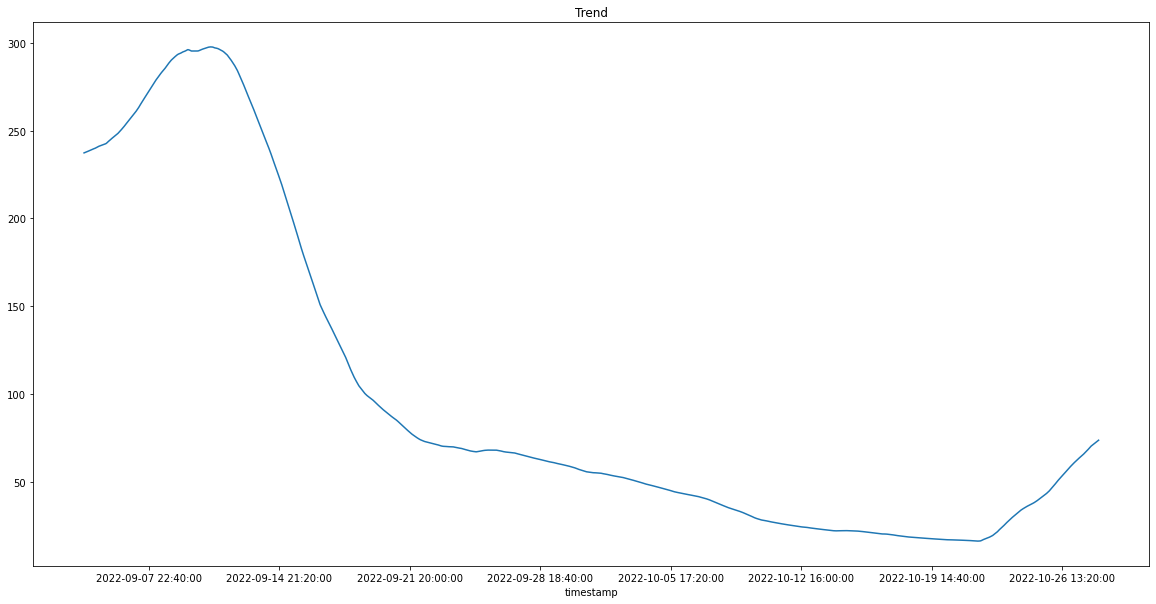

In [88]:
fig, ax = plt.subplots(1, figsize = (20,10))
ax.set_title('Trend')
trend.plot()

<AxesSubplot:title={'center':'Seasonality'}, xlabel='timestamp'>

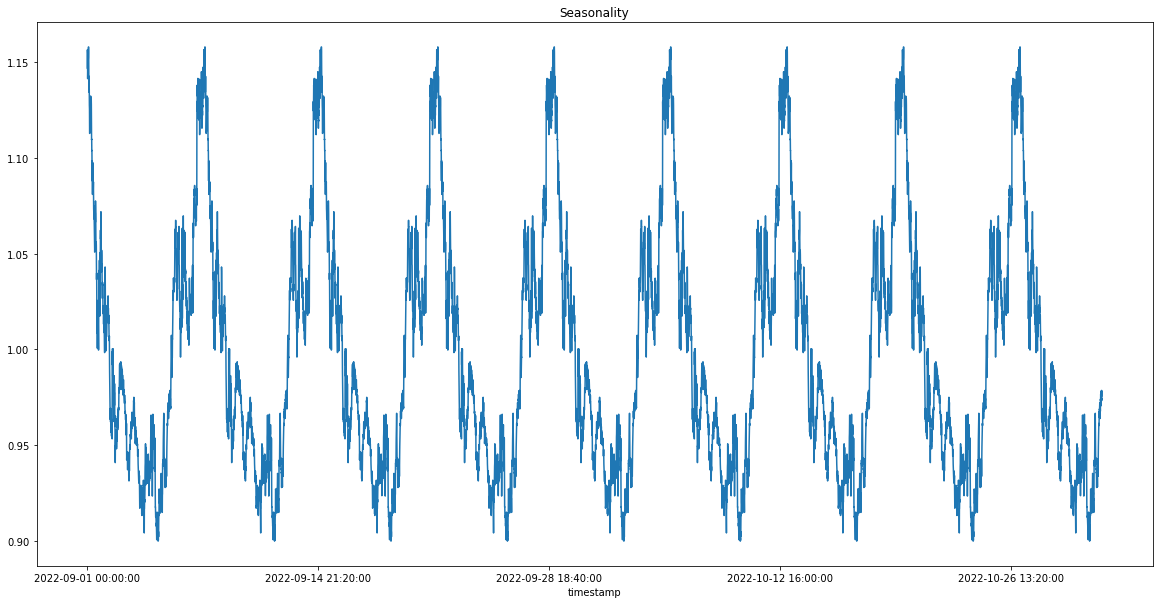

In [89]:
fig, ax = plt.subplots(1, figsize = (20,10))
ax.set_title('Seasonality')
seasonal.plot()

<AxesSubplot:title={'center':'Residuals'}, xlabel='timestamp'>

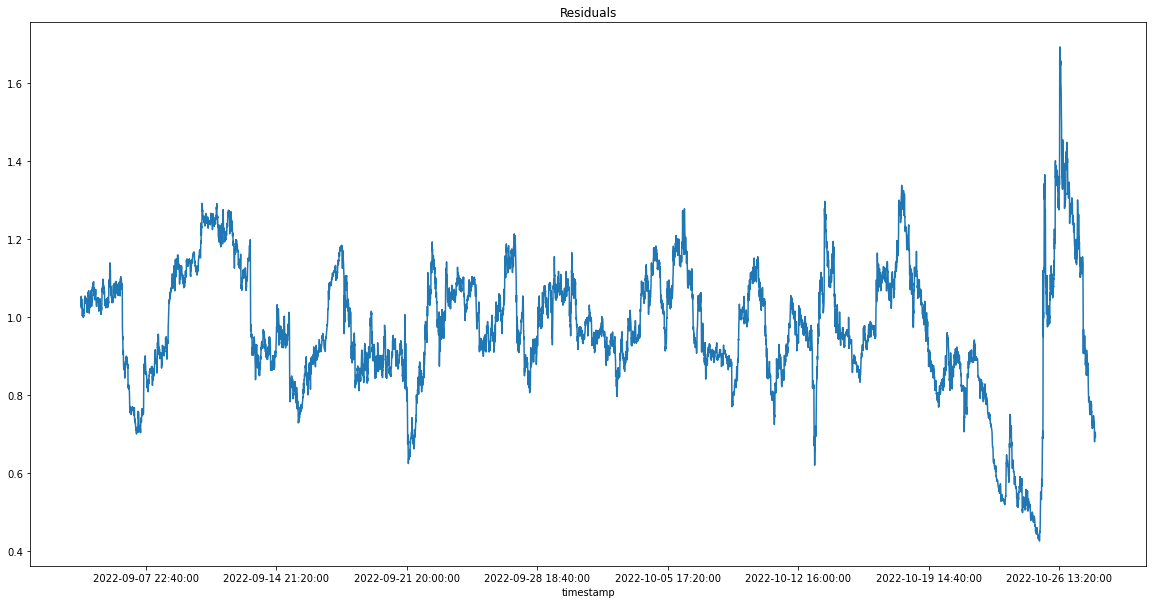

In [90]:
fig, ax = plt.subplots(1, figsize = (20,10))
ax.set_title('Residuals')
residual.plot()

### Testing for stationary with KPSS

In [91]:
from statsmodels.tsa.stattools import kpss
kpss(y)

/Users/quinn/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(10.709769475733038,
 0.01,
 56,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value is less than 0.05, so this time series is not stationary. We need to do some transformations. In particular, we add log_volume, log_price, time_to_expiry and return columns to the existing dataframe. These information is useful for option price prediction and is needed in Black-Scholes model.

In [188]:
#add log_price, log_volume, 
df['log_price'] = np.log(df['price'])
df['log_volume'] = np.log(df['volume'])
df['return'] = df['price'].diff(1)

/Users/quinn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [189]:
#add time_to_expiry column
expiry = datetime.datetime.strptime('2022-11-25 00:00:00', '%Y-%m-%d %H:%M:%S')
df['time_to_expiry'] = df['timestamp']
df['time_to_expiry'] = df['time_to_expiry'].map(lambda x: expiry - dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
#df['time_to_expiry'] = df['time_to_expiry']/(365*24*360)

In [190]:
df.head()

,timestamp,spot,price,volume,log_price,log_volume,return,time_to_expiry
0,2022-09-01 00:00:00,1564.625,238.996469,67628.0,5.476449,11.121777,NaN,85 days 00:00:00
1,2022-09-01 00:10:00,1557.725,235.216475,65656.0,5.460506,11.092184,-3.779994,84 days 23:50:00
2,2022-09-01 00:20:00,1556.975,235.103225,64104.0,5.460025,11.068262,-0.113250,84 days 23:40:00
3,2022-09-01 00:30:00,1545.425,229.495612,95785.0,5.435884,11.469861,-5.607613,84 days 23:30:00
4,2022-09-01 00:40:00,1541.975,227.441313,157334.0,5.426892,11.966126,-2.054300,84 days 23:20:00


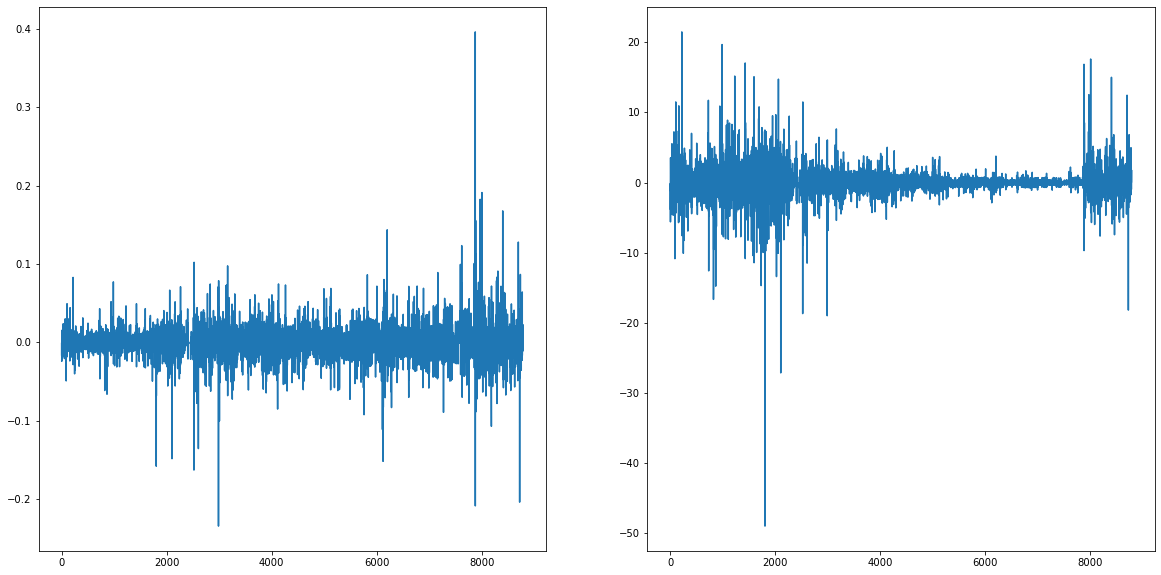

In [146]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
ax[0].plot(df['log_price'].diff(1).dropna(), linestyle='-')
ax[1].plot(df['return'], linestyle='-')
plt.show()

The graphs above appear to be non-stationary. Therefore, we propose using ARIMA model instead of ARMA model.

### Train test split

In [191]:
#train_test split
split = int(df.shape[0]*0.7)
df_train = df[:split]
df_test = df[split:]

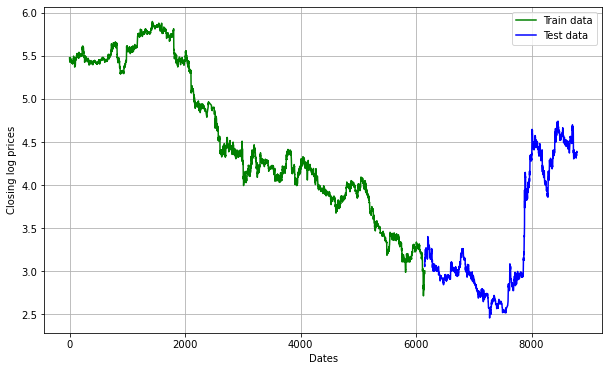

In [192]:
train_data, test_data = df_train['log_price'], df_test['log_price']
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing log prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

## ARIMA model

In [152]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[31] intercept   : AIC=-33274.564, Time=24.56 sec
 ARIMA(0,1,0)(0,0,0)[31] intercept   : AIC=-33276.170, Time=0.89 sec
 ARIMA(1,1,0)(1,0,0)[31] intercept   : AIC=-33290.728, Time=35.34 sec
 ARIMA(0,1,1)(0,0,1)[31] intercept   : AIC=-33290.764, Time=42.19 sec
 ARIMA(0,1,0)(0,0,0)[31]             : AIC=-33274.356, Time=0.34 sec


/Users/quinn/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[31] intercept   : AIC=-33292.270, Time=0.51 sec


/Users/quinn/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,0,0)[31] intercept   : AIC=-33290.750, Time=35.04 sec
 ARIMA(0,1,1)(1,0,1)[31] intercept   : AIC=-33288.894, Time=46.88 sec


/Users/quinn/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/quinn/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[31] intercept   : AIC=-33290.237, Time=0.88 sec
 ARIMA(0,1,2)(0,0,0)[31] intercept   : AIC=-33290.288, Time=1.99 sec


/Users/quinn/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,0,0)[31] intercept   : AIC=-33292.237, Time=0.36 sec


/Users/quinn/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/quinn/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,2)(0,0,0)[31] intercept   : AIC=-33288.310, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[31]             : AIC=-33289.998, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[31] intercept
Total fit time: 189.914 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6148
Model:               SARIMAX(0, 1, 1)   Log Likelihood               16649.135
Date:                Sat, 18 Feb 2023   AIC                         -33292.270
Time:                        17:59:11   BIC                         -33272.098
Sample:                             0   HQIC                        -33285.273
                               - 6148                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

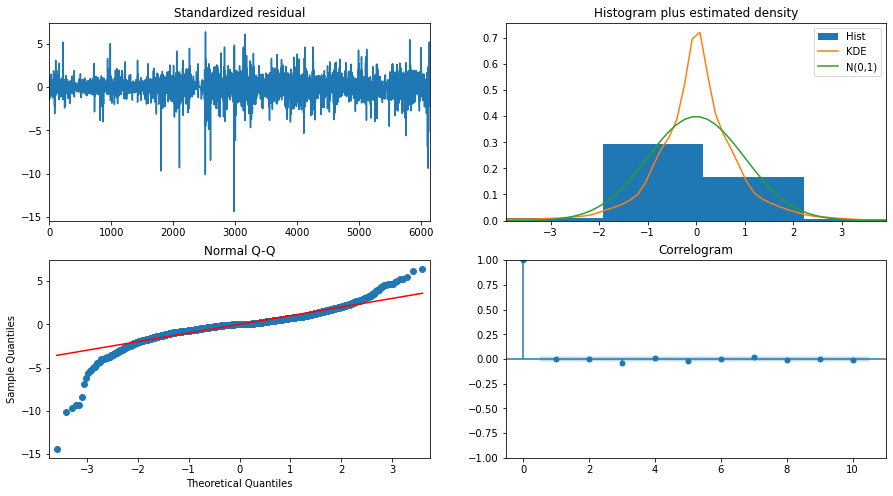

In [153]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=31,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

The best model is ARIMA(0,1,1). We use this model for prediction.

In [154]:
model = ARIMA(train_data, order=(0,1,1))  
fitted = model.fit()

### Forecasting

In [161]:
#prediction with 95% confidence
forecast = fitted.get_forecast(len(test_data)).conf_int(alpha=0.05)

Text(0.5, 1.0, 'ARIMA prediction for option price')

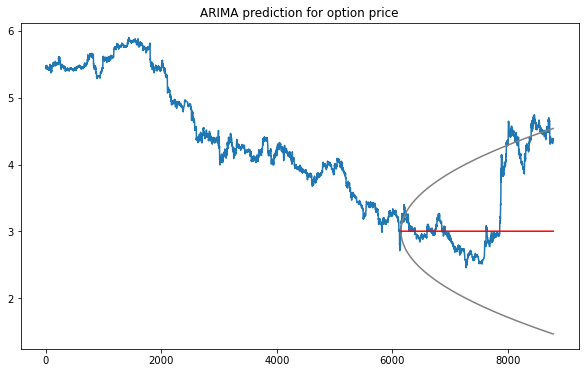

In [165]:
plt.figure(figsize=(10,6))
plt.plot(list(train_data) + list(test_data))
plt.plot([None]*len(train_data) + list(fitted.forecast(len(test_data))), color = 'red')
plt.plot([None]*len(train_data) + list(forecast['lower log_price']), color = 'gray')
plt.plot([None]*len(train_data) + list(forecast['upper log_price']), color = 'gray')
plt.title('ARIMA prediction for option price')

### Evaluations

In [173]:
#report performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
predict = fitted.forecast(len(test_data))
mse = mean_squared_error(predict, test_data)
print('MSE:' + str(mse))
mae = mean_absolute_error(predict, test_data)
print('MAE:' + str(mae))

MSE:0.679274841010636
MAE:0.5813944437080252


## Black-Scholes model

Our Black-Scholes model has following parameters:
- Interest rate: r = 0 (the time is short, so we assume r = 0)
- Strike price: K = 1700
- Expiry date: Nov 22, 2023
- Volatility: we choose 6-week average volatility and 2-week average volatility for our model

In [169]:
#Black-Scholes function
def BS_closed_form(option_type, S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        return S0 * ss.norm.cdf(d1) - K * np.exp(-r*T) * ss.norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r*T) * ss.norm.cdf(-d2) - S0 * ss.norm.cdf(-d1)

### Black-Scholes model with 6-week average volatility

We first compute the 6-week average volatility.

In [227]:
df_train['diff'] = df_train['log_price'].diff(1)
df_train['diff'] = df_train['diff']**2
vol = np.mean(df_train['diff'][1:])
vol = np.sqrt(vol)*np.sqrt(365*24)

/var/folders/xh/6n75v1rx49x84p1xp7xtrs680000gn/T/ipykernel_50170/3345064809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['diff'] = df_train['log_price'].diff(1)
/var/folders/xh/6n75v1rx49x84p1xp7xtrs680000gn/T/ipykernel_50170/3345064809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['diff'] = df_train['diff']**2


In [195]:
df_test['time_to_expiry'] = df_test['time_to_expiry'].dt.days.astype('int16')
df_test['time_to_expiry'] = df_test['time_to_expiry']/365

/var/folders/xh/6n75v1rx49x84p1xp7xtrs680000gn/T/ipykernel_50170/2313541001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['time_to_expiry'] = df_test['time_to_expiry'].dt.days.astype('int16')
/var/folders/xh/6n75v1rx49x84p1xp7xtrs680000gn/T/ipykernel_50170/2313541001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['time_to_expiry'] = df_test['time_to_expiry']/365


In [228]:
spot = df['spot'][split] #spot price is the last spot price we can observe
df_test['BS_price'] = df_test['spot']
for i in range(df_test.index.start,df_test.index.stop):
    df_test['BS_price'][i] = BS_closed_form('call', spot, 1700, 0, vol, df_test['time_to_expiry'][i])

/var/folders/xh/6n75v1rx49x84p1xp7xtrs680000gn/T/ipykernel_50170/4056667912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['BS_price'] = df_test['spot']
/var/folders/xh/6n75v1rx49x84p1xp7xtrs680000gn/T/ipykernel_50170/4056667912.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['BS_price'][i] = BS_closed_form('call', spot, 1700, 0, vol, df_test['time_to_expiry'][i])


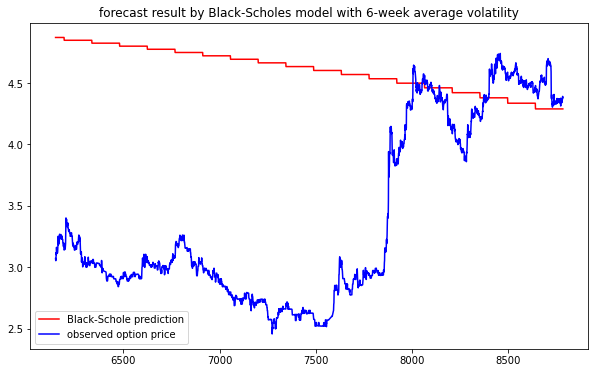

In [229]:
plt.figure(figsize = (10,6))
plt.plot(np.log(df_test['BS_price']), color = 'red', label = 'Black-Schole prediction')
plt.plot(test_data, color = 'blue', label = 'observed option price')
plt.title('forecast result by Black-Scholes model with 6-week average volatility')
plt.legend()

### Evaluate performance

In [230]:
mse = mean_squared_error(np.log(df_test['BS_price']), test_data)
mae = mean_absolute_error(np.log(df_test['BS_price']), test_data)
print('MSE for BS model with 6-week average volatility is ', mse, 'and MAE is ', mae)

MSE for BS model with 6-week average volatility is  2.213616025102566 and MAE is  1.268879078348709


### Black-Scholes model with 1-week average volatility

In [219]:
#compute 2-week average volatility
vol = np.mean(df_train['diff'][df_train.index.stop - 7:])
vol = np.sqrt(vol)*np.sqrt(365*24)

In [220]:
for i in range(df_test.index.start,df_test.index.stop):
    df_test['BS_price'][i] = BS_closed_form('call', spot, 1700, 0, vol, df_test['time_to_expiry'][i])

/var/folders/xh/6n75v1rx49x84p1xp7xtrs680000gn/T/ipykernel_50170/2932862941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['BS_price'][i] = BS_closed_form('call', spot, 1700, 0, vol, df_test['time_to_expiry'][i])


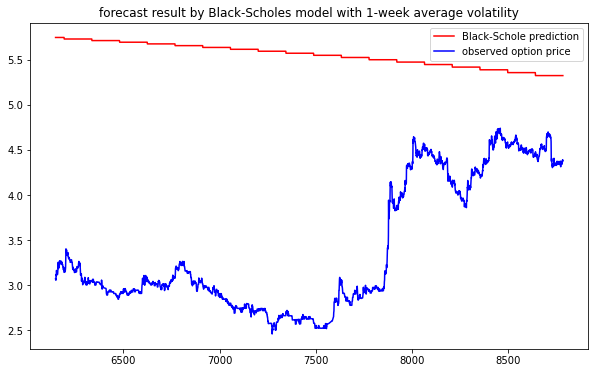

In [222]:
plt.figure(figsize = (10,6))
plt.plot(np.log(df_test['BS_price']), color = 'red', label = 'Black-Schole prediction')
plt.plot(test_data, color = 'blue', label = 'observed option price')
plt.title('forecast result by Black-Scholes model with 1-week average volatility')
plt.legend()

### Evaluate performance

In [225]:
mse = mean_squared_error(np.log(df_test['BS_price']), test_data)
mae = mean_absolute_error(np.log(df_test['BS_price']), test_data)
print('MSE for BS model with 1-week average volatility is ', mse, 'and MAE is ', mae)

MSE for BS model with 1-week average volatility is  5.342896083911278 and MAE is  2.158917863607934
